In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import keras.backend as K

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
IMAGES_DIRECTORY = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/images")
LABELS_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/dataset/market_dataset_xy.txt")
DRONET_PATH = os.path.join("/kaggle/input/marketplace-navigation-dataset/model.keras")

# Loading Dataset

In [3]:
original_df = pd.read_csv(LABELS_PATH, sep=" ", header=None)
original_df.columns = ["file name", "-", "datetime", "y_vel", "x_vel"]

df = pd.DataFrame()
df["file path"] = original_df["file name"].apply(lambda file_name: os.path.join(IMAGES_DIRECTORY, file_name))
df["x_vel"] = original_df["x_vel"]
df["y_vel"] = original_df["y_vel"]

df

,file path,x_vel,y_vel
0,/kaggle/input/marketplace-navigation-dataset/d...,0.0390,0.0253
1,/kaggle/input/marketplace-navigation-dataset/d...,-0.0693,0.0593
2,/kaggle/input/marketplace-navigation-dataset/d...,0.0233,0.1089
3,/kaggle/input/marketplace-navigation-dataset/d...,0.0485,0.1407
4,/kaggle/input/marketplace-navigation-dataset/d...,-0.0469,0.1870
...,...,...,...
2265,/kaggle/input/marketplace-navigation-dataset/d...,0.0303,0.1485
2266,/kaggle/input/marketplace-navigation-dataset/d...,-0.0346,0.1026
2267,/kaggle/input/marketplace-navigation-dataset/d...,0.0760,0.0966
2268,/kaggle/input/marketplace-navigation-dataset/d...,-0.0563,0.0644


In [4]:
def load_images(df, target_size: tuple[int, int]=(224, 224), color_mode: str="rgb"):
    X = []
    y = []
    
    for file_path, x_vel, y_vel in tqdm(df.itertuples(index=False, name=None)):
        image = keras.utils.load_img(
            file_path,
            color_mode=color_mode,
            target_size=target_size,
            interpolation="bilinear",
        )
        image = np.asarray(image, dtype=np.float32) / 255.0  # Efficient conversion
    
        X.append(image)
        y.append([x_vel, y_vel])
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [5]:
X, y = load_images(df, target_size=(200, 200), color_mode="grayscale")

# Split samples into train (60%), validation(20%) and test(20%) subsets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    train_size=0.6,
    shuffle=True,
    random_state=0,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    train_size=0.5,
    shuffle=True,
    random_state=0,
)

0it [00:00, ?it/s]

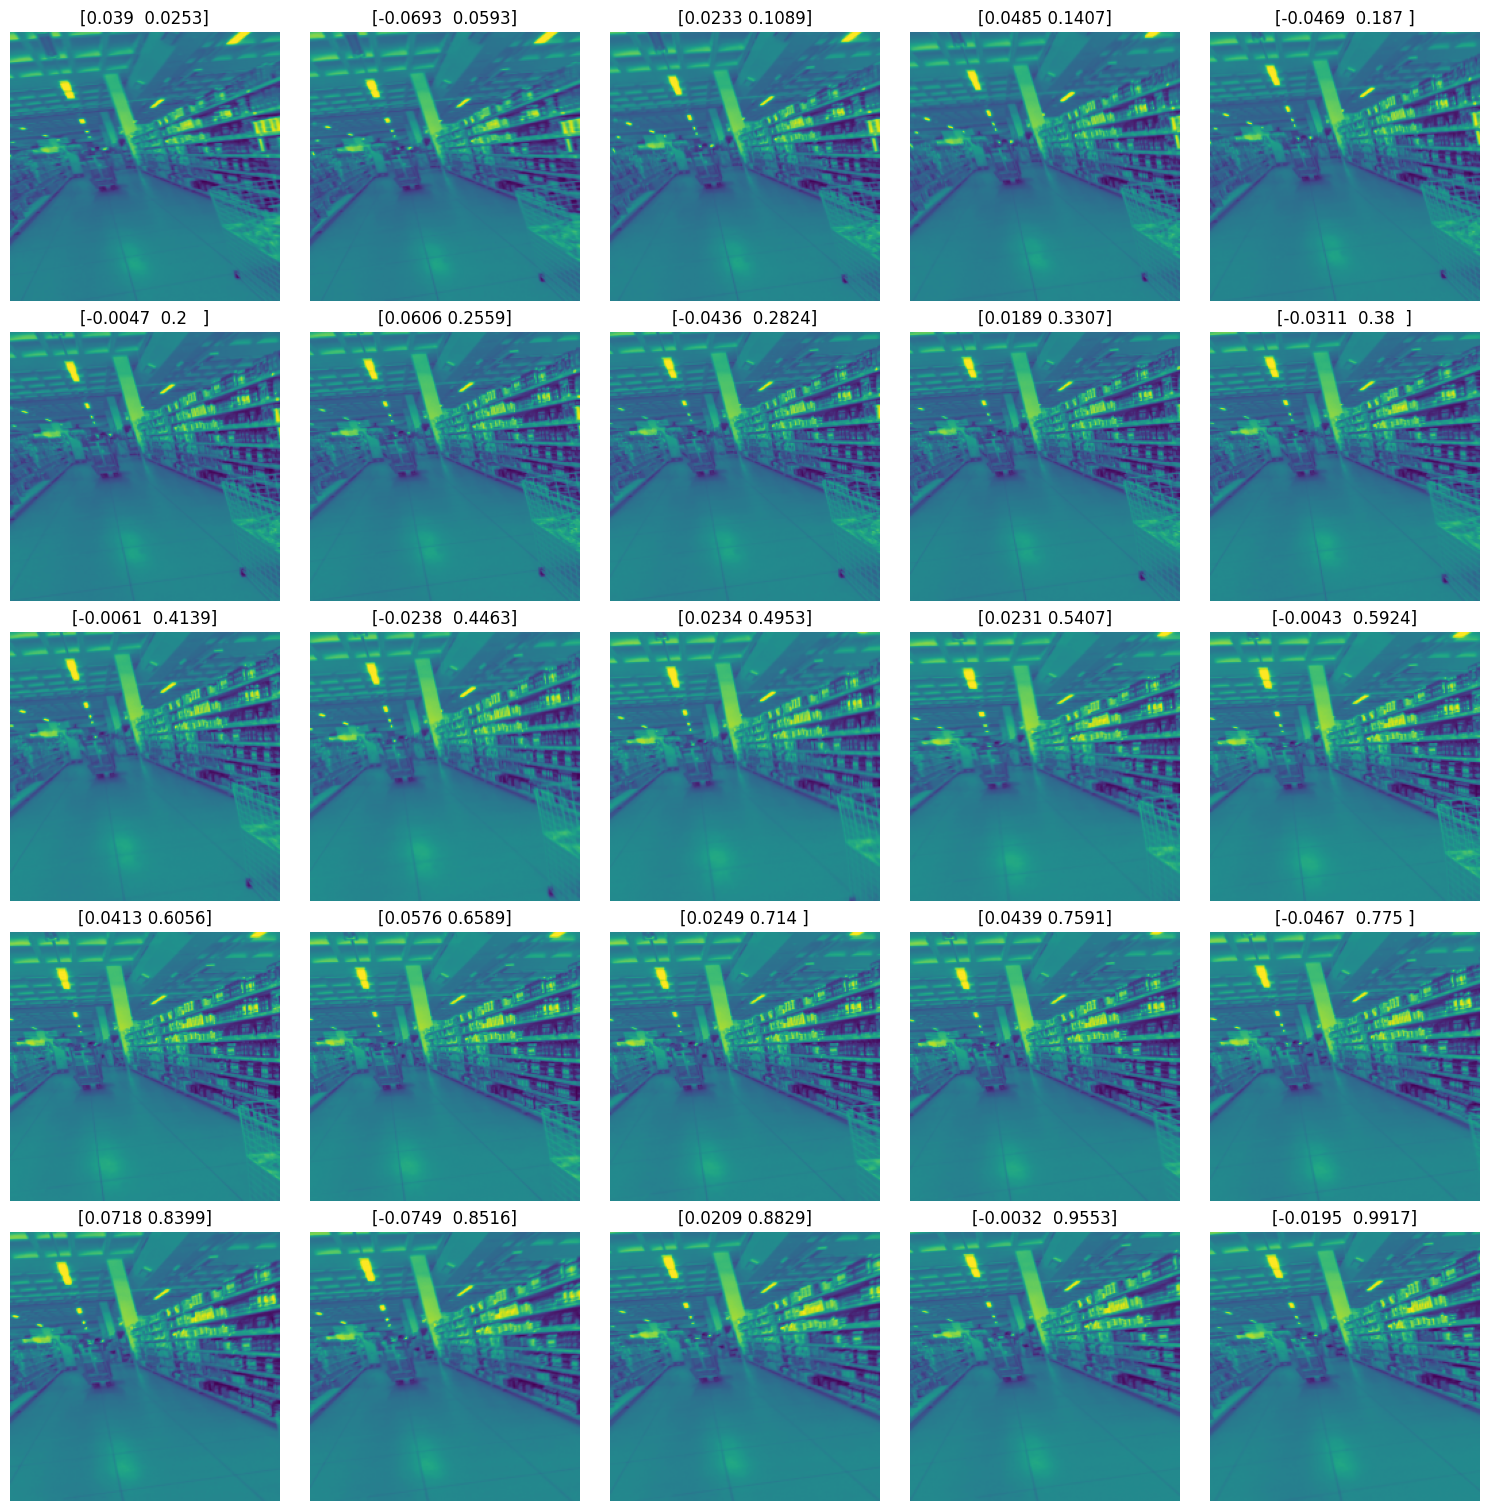

In [6]:
indices = np.arange(0, X.shape[0])
# np.random.shuffle(indices)
indices = indices[:25]

plt.subplots(5, 5, figsize=(15, 15), layout="constrained")
for index, sample_index in enumerate(indices):
    plt.subplot(5, 5, index + 1)
    plt.title(str(y[sample_index]))
    plt.imshow(X[sample_index])
    plt.axis("off")

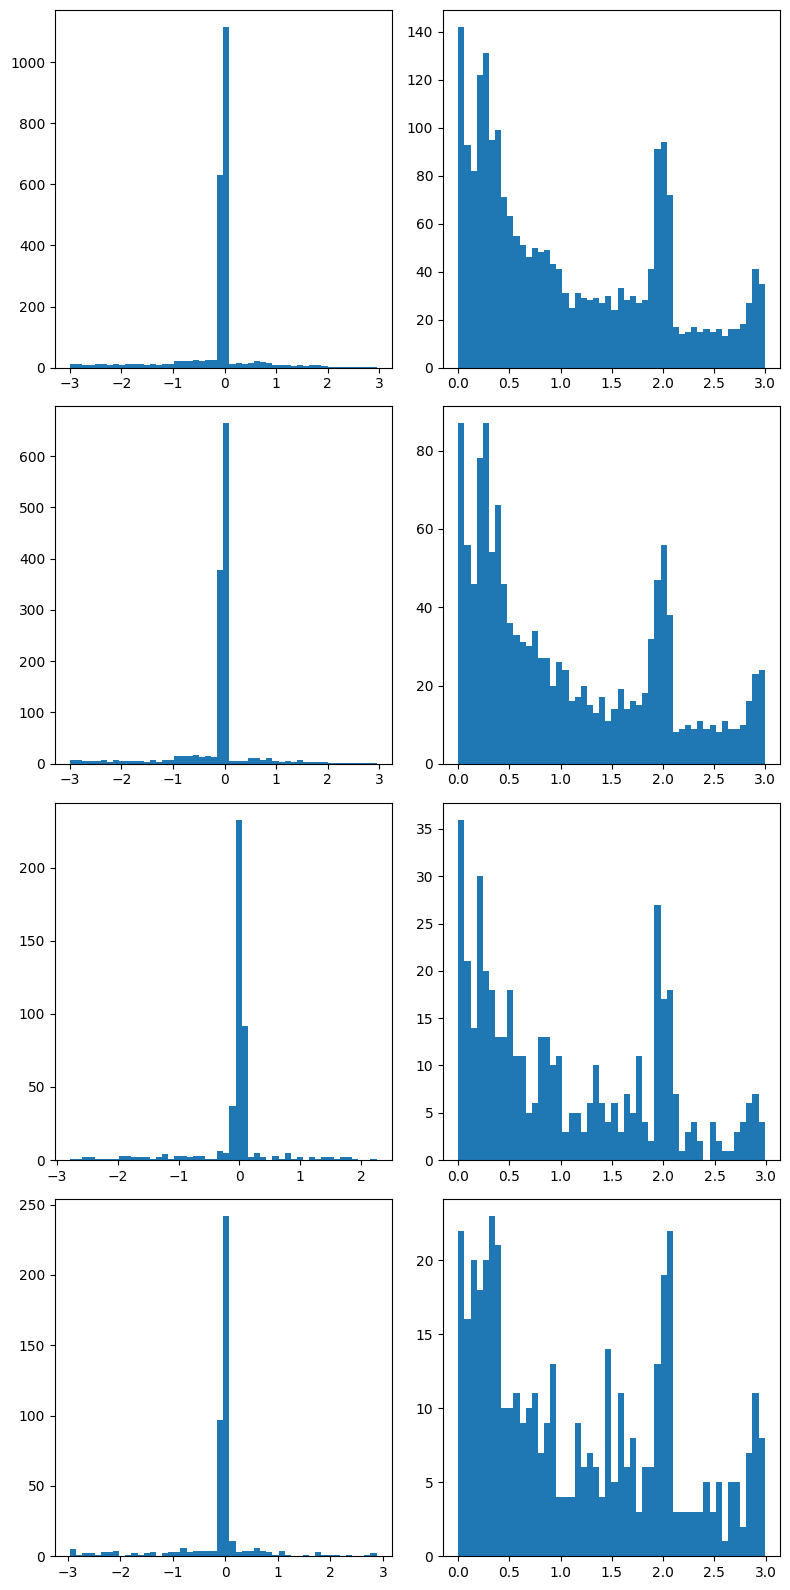

In [7]:
def plot_velocities_distribution(data=[]):
    rows = len(data)
    columns = 2

    fig, ax = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4), layout="tight")

    for i, labels in enumerate(data):
        x_vel = labels[:, 0]
        y_vel = labels[:, 1]

        ax[i, 0].hist(x_vel, bins=50)
        ax[i, 1].hist(y_vel, bins=50)

plot_velocities_distribution([y, y_train, y_test, y_val])

In [8]:
from keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        batch_X = np.array([self.X[i] for i in batch_indexes])
        batch_y = np.array([self.y[i] for i in batch_indexes])

        batch_y_dict = {
            "Dronet_output_x": batch_y[:, 0],
            "Dronet_output_y": batch_y[:, 1],
        }

        return batch_X, batch_y_dict

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [9]:
def mae(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.reduce_sum(tf.abs(y_true - y_pred))

def r2_score(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    
    return 1 - (ss_res / (ss_tot + K.epsilon()))
    
def rmse(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])
    
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def eva(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, 1])

    numerator = tf.math.reduce_variance(y_true - y_pred)
    denominator = tf.math.reduce_variance(y_true) + tf.keras.backend.epsilon()
    
    return 1.0 - numerator / denominator

    
def create_dronet(learning_rate, bottom_layers=(1024,)):
    base = keras.models.load_model(DRONET_PATH)
    base.name = "Dronet_cnn_layers"
    base.trainable = False
    
    inputs = base.input
    conv_layers = base.output

    if len(conv_layers.shape) > 2:
        s = keras.layers.Flatten(name="Dronet_flatten")(conv_layers)
    else:
        s = conv_layers  

    s = keras.layers.ReLU(name="Dronet_relu")(s)
    s = keras.layers.Dropout(0.5, name="Dronet_shared_dropout")(s)

    # Two independent branches
    x = s
    i = 1
    for n in bottom_layers:
        name = "Dronet_dense_x_" + str(i)
        i += 1
        
        x = keras.layers.Dense(n, activation="relu", name=name)(x)

    y = s
    i = 1
    for n in bottom_layers:
        name = "Dronet_dense_y_" + str(i)
        i += 1
        
        y = keras.layers.Dense(n, activation="relu", name=name)(y)

    outputs = [
        keras.layers.Dense(1, activation="linear", name="Dronet_output_x")(x),
        keras.layers.Dense(1, activation="linear", name="Dronet_output_y")(y),
    ]

    model = keras.Model(inputs=inputs, outputs=outputs, name="Dronet")

    model.compile(
        loss={
            "Dronet_output_x": "mean_squared_error",
            "Dronet_output_y": "mean_squared_error",
        },
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics={
            "Dronet_output_x": [eva, rmse, r2_score],
            "Dronet_output_y": [eva, rmse, r2_score],
        },
    )

    return model

I0000 00:00:1742914875.469218      67 service.cc:145] XLA service 0x7ebcdc002cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742914875.469303      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1742914878.545402      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Dronet_output_x_eva: 0.8427 - Dronet_output_x_r2_score: 0.8362 - Dronet_output_x_rmse: 0.1998 - Dronet_output_y_eva: 0.9206 - Dronet_output_y_r2_score: 0.9081 - Dronet_output_y_rmse: 0.2557 - loss: 0.1115
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Dronet_output_x_eva: 0.8280 - Dronet_output_x_r2_score: 0.8258 - Dronet_output_x_rmse: 0.1845 - Dronet_output_y_eva: 0.9291 - Dronet_output_y_r2_score: 0.9222 - Dronet_output_y_rmse: 0.2258 - loss: 0.0908
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Dronet_output_x_eva: 0.8842 - Dronet_output_x_r2_score: 0.8793 - Dronet_output_x_rmse: 0.1433 - Dronet_output_y_eva: 0.9599 - Dronet_output_y_r2_score: 0.9582 - Dronet_output_y_rmse: 0.1671 - loss: 0.0553
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Dronet_output_x_eva: 0.9093 - Dronet_output_x_r2_score: 0.9068 - Dronet_output_x_rmse: 0.1467 - Drone

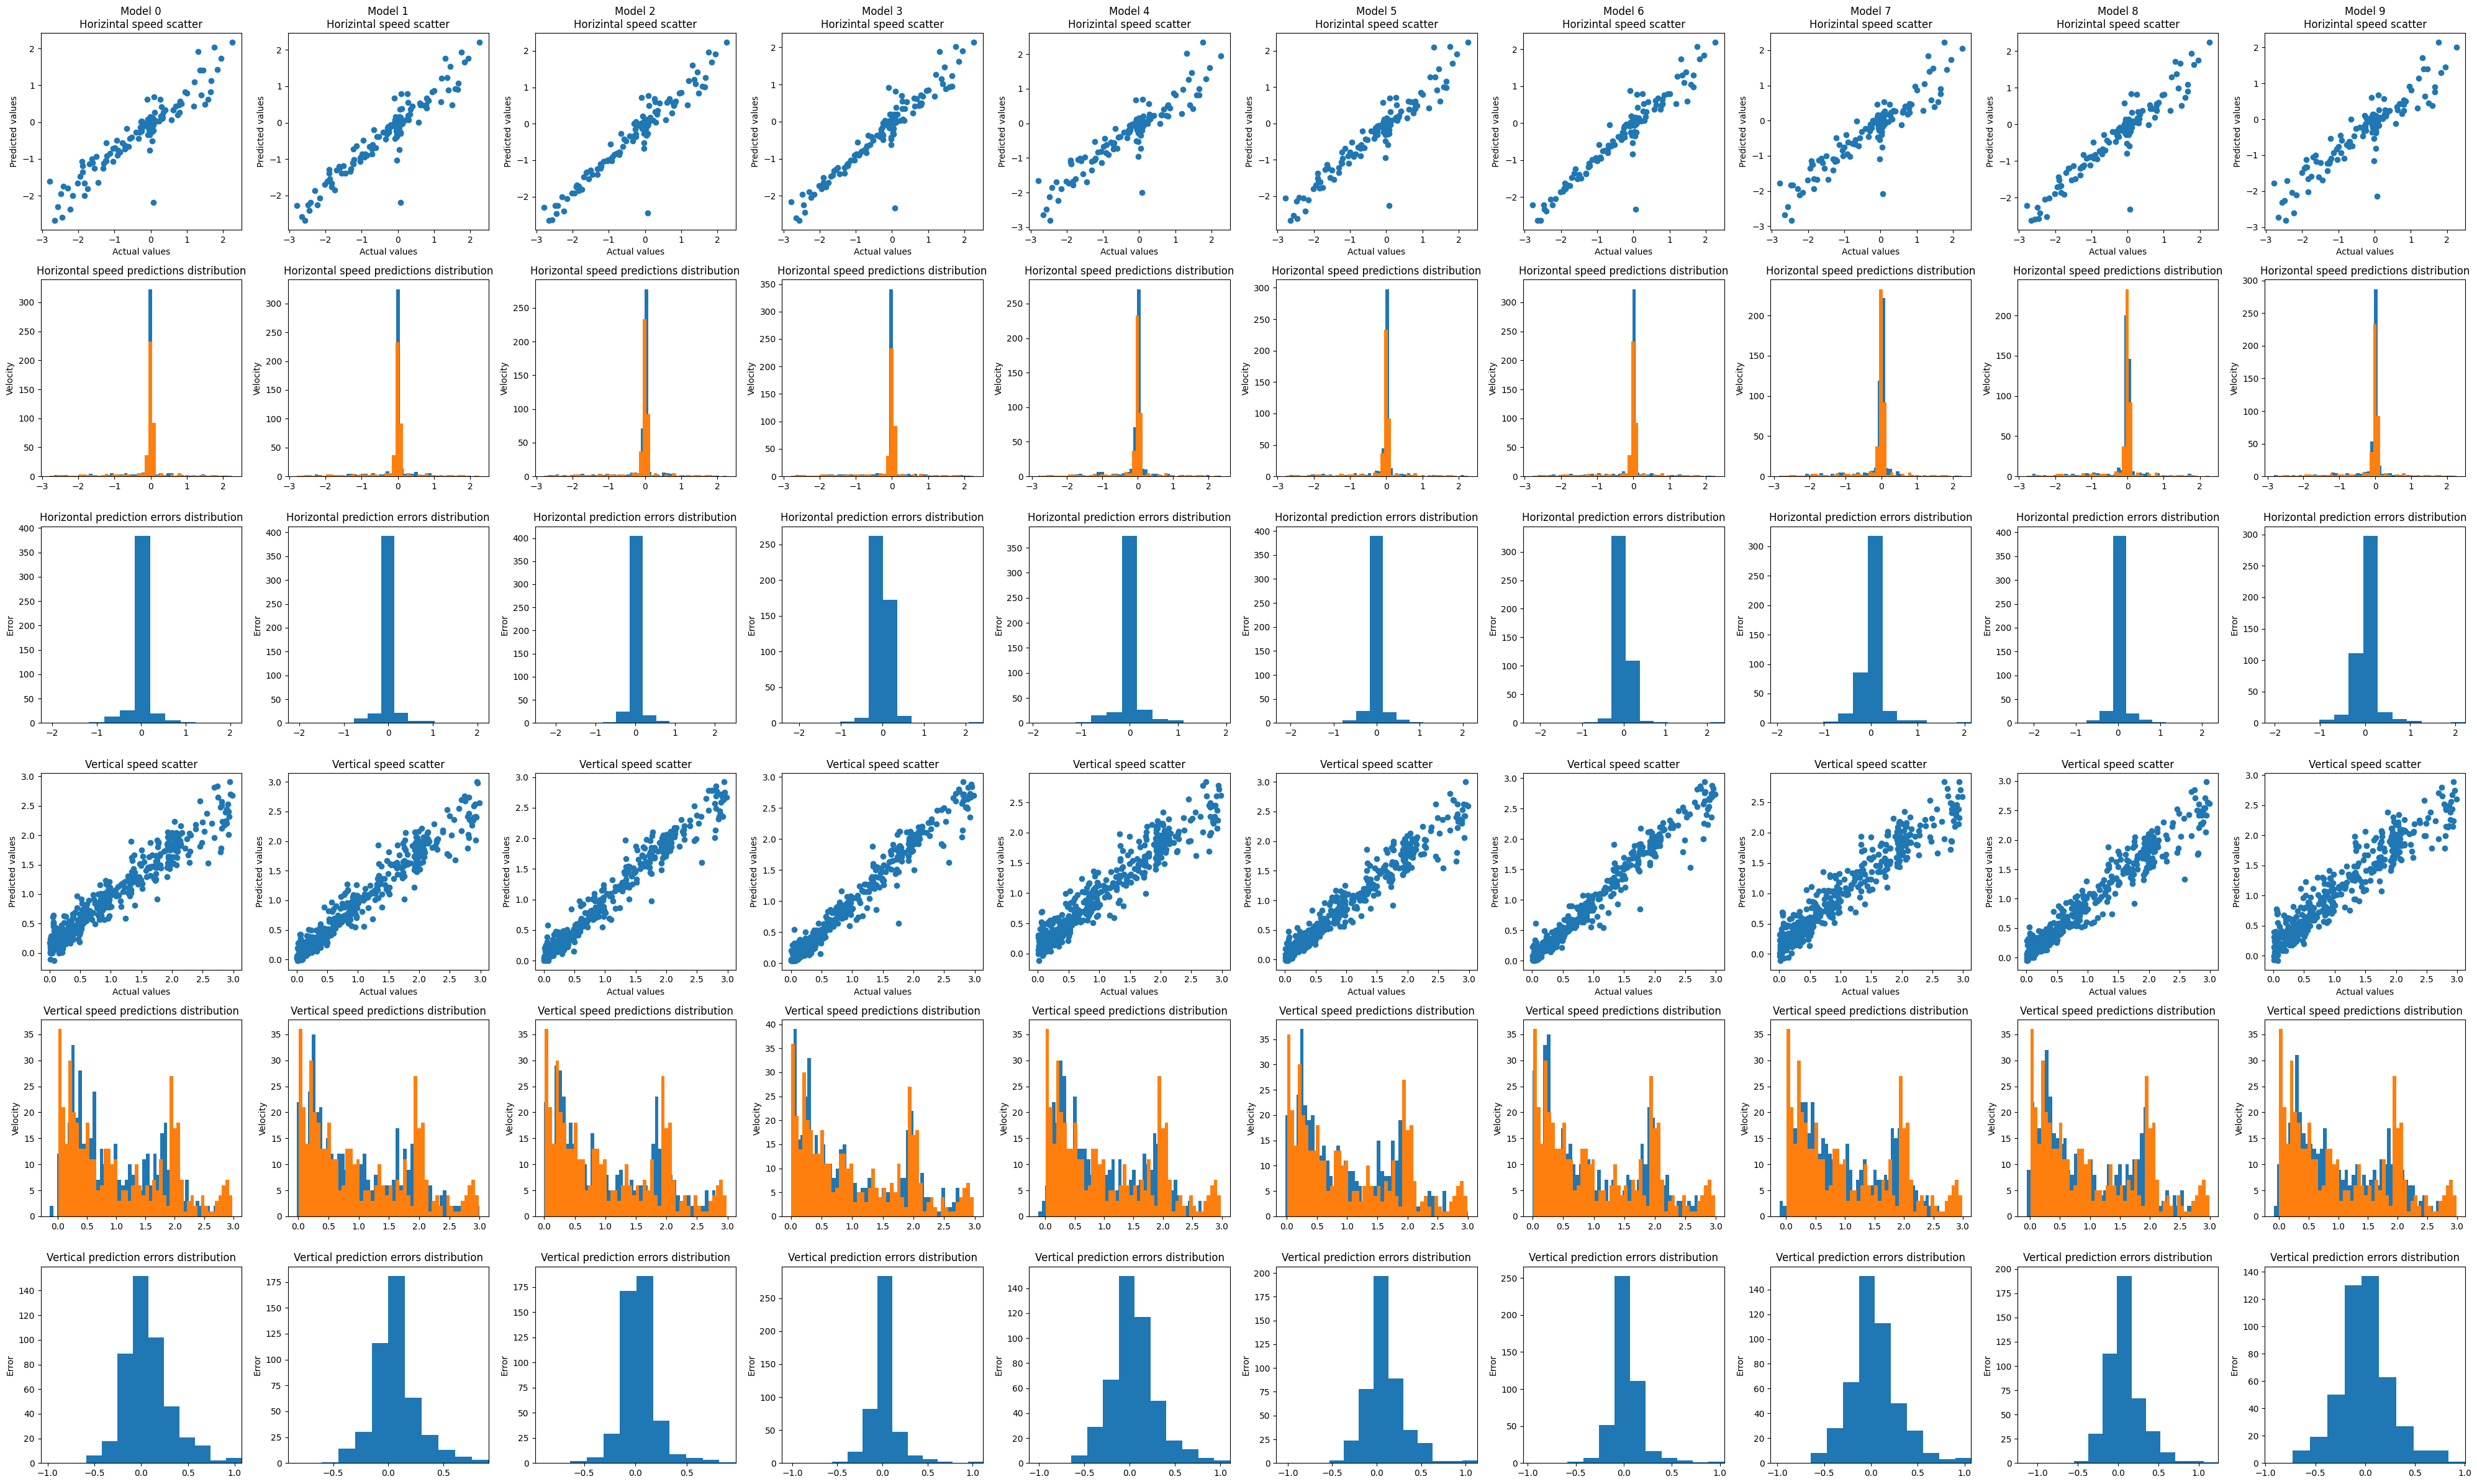

In [10]:
dronets = [
    create_dronet(0.001, bottom_layers=(1024,)),
    create_dronet(0.001, bottom_layers=(1024, 512)),
    create_dronet(0.001, bottom_layers=(1024, 512, 256)),
    create_dronet(0.001, bottom_layers=(1024, 512, 256, 128)),
    create_dronet(0.001, bottom_layers=(512,)),
    create_dronet(0.001, bottom_layers=(512, 256)),
    create_dronet(0.001, bottom_layers=(512, 256, 128)),
    create_dronet(0.001, bottom_layers=(256,)),
    create_dronet(0.001, bottom_layers=(256, 128)),
    create_dronet(0.001, bottom_layers=(128,)),
]

rows = 6
columns = len(dronets)
figsize = (columns * 4, rows * 4)

data = {}
fig, ax = plt.subplots(rows, columns, figsize=figsize, layout="tight")

for i, dronet in enumerate(dronets):
    column_name = f"Model {i}"
    
    y_train_scaled = y_train
    y_val_scaled = y_val
    y_test_scaled = y_test
    
    # Creation of the data generators
    train_dataset = DataGenerator(X_train, y_train_scaled)
    validation_dataset = DataGenerator(X_val, y_val_scaled)
    test_dataset = DataGenerator(X_test, y_test_scaled)

    # Training
    history = dronet.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=150,
        callbacks=[
            # keras.callbacks.EarlyStopping(
            #     monitor="val_Dronet_output_x_rmse",
            #     patience=20,
            #     min_delta=0.0001,
            #     mode="min"
            # ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_Dronet_output_x_rmse',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            ),
        ],
        verbose=0,
    )

    # Evaluation
    metric_names = ["MSE", "Horizontal EVA", "Horizontal R²", "Horizontal RMSE", "Vertical EVA", "Vertical R²", "Vertical RMSE"]
    metric_values = dronet.evaluate(test_dataset)
    data[column_name] = dict(zip(metric_names, metric_values))
    
    y_pred = dronet.predict(X_test)
    y_pred = np.hstack(y_pred)

    x_residuals = y_test_scaled[:, 0] - y_pred[:, 0]
    x_limits = np.max(np.fabs(x_residuals))
    x_limits = (-x_limits, +x_limits)

    y_residuals = y_test_scaled[:, 1] - y_pred[:, 1]
    y_limits = np.max(np.fabs(y_residuals))
    y_limits = (-y_limits, +y_limits)

    ax[0, i].scatter(y_test_scaled[:, 0], y_pred[:, 0])
    ax[0, i].set_title(f"{column_name}\nHorizintal speed scatter")
    ax[0, i].set_xlabel("Actual values")
    ax[0, i].set_ylabel("Predicted values")
    
    ax[1, i].hist(y_pred[:, 0], bins=50)
    ax[1, i].hist(y_test_scaled[:, 0], bins=50)
    ax[1, i].set_title("Horizontal speed predictions distribution")
    ax[1, i].set_ylabel("Velocity")
    
    ax[2, i].hist(x_residuals)
    ax[2, i].set_title("Horizontal prediction errors distribution")
    ax[2, i].set_ylabel("Error")
    ax[2, i].set_xlim(x_limits)

    ax[3, i].scatter(y_test_scaled[:, 1], y_pred[:, 1])
    ax[3, i].set_title("Vertical speed scatter")
    ax[3, i].set_xlabel("Actual values")
    ax[3, i].set_ylabel("Predicted values")
    
    ax[4, i].hist(y_pred[:, 1], bins=50)
    ax[4, i].hist(y_test_scaled[:, 1], bins=50)
    ax[4, i].set_title("Vertical speed predictions distribution")
    ax[4, i].set_ylabel("Velocity")
    
    ax[5, i].hist(y_residuals)
    ax[5, i].set_title("Vertical prediction errors distribution")
    ax[5, i].set_ylabel("Error")
    ax[5, i].set_xlim(y_limits)

metrics = pd.DataFrame(data)
print(metrics.T)

<Axes: >

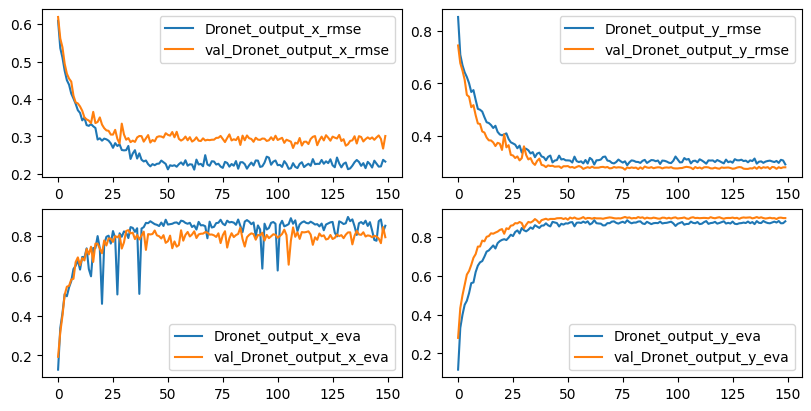

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8, 4), layout="constrained")

pd.DataFrame(history.history)[
    [
        "Dronet_output_x_rmse",
        "val_Dronet_output_x_rmse"
    ]
].plot(ax=ax[0, 0])

pd.DataFrame(history.history)[
    [
        "Dronet_output_y_rmse",
        "val_Dronet_output_y_rmse"
    ]
].plot(ax=ax[0, 1])

pd.DataFrame(history.history)[
    [
        "Dronet_output_x_eva",
        "val_Dronet_output_x_eva"
    ]
].plot(ax=ax[1, 0])

pd.DataFrame(history.history)[
    [
        "Dronet_output_y_eva",
        "val_Dronet_output_y_eva"
    ]
].plot(ax=ax[1, 1])

In [12]:
history.history["val_Dronet_output_x_rmse"]

[0.6196884512901306,
 0.5621213912963867,
 0.5382220149040222,
 0.494657039642334,
 0.4679771363735199,
 0.4546622633934021,
 0.44666534662246704,
 0.40908411145210266,
 0.39103570580482483,
 0.3882552981376648,
 0.3800685703754425,
 0.3685733675956726,
 0.35073843598365784,
 0.3454565405845642,
 0.34243258833885193,
 0.3355207145214081,
 0.3657061755657196,
 0.33559802174568176,
 0.33867985010147095,
 0.3508385121822357,
 0.3316803276538849,
 0.3220403492450714,
 0.3161364495754242,
 0.3149651885032654,
 0.30492010712623596,
 0.30484557151794434,
 0.317555695772171,
 0.2934640049934387,
 0.2812248170375824,
 0.3341614305973053,
 0.30517950654029846,
 0.29115697741508484,
 0.2955322861671448,
 0.2846511900424957,
 0.28876736760139465,
 0.2852502763271332,
 0.297239750623703,
 0.30111950635910034,
 0.3006746470928192,
 0.2859727442264557,
 0.29469797015190125,
 0.30357998609542847,
 0.2835101783275604,
 0.29038217663764954,
 0.2867124080657959,
 0.29828351736068726,
 0.3003028929233551,